# **Introduction**

In this Jupiter notebook, you are creating a Convolutional Neural Network (CNN) using TensorFlow and Keras to classify brain MRI images. The goal is to detect potential brain tumors through the analysis of MRI images. In this section, we import the necessary libraries to create the CNN and load the images.

# **Importing Libraries**

In this paragraph, we have imported the necessary libraries to create the CNN. TensorFlow and Keras are the main frameworks that we will use to create the convolutional neural network. Additionally, we have imported other useful libraries such as OpenCV (cv2) for image preprocessing, PIL for image manipulation, and Matplotlib for image visualization.

In [ ]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
import os
import glob
import shutil
from sklearn.utils import shuffle
import zipfile
import cv2
import imutils
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# **Fetch data**

In the following code snippet, we are mounting the Google Drive to access the dataset required for training the CNN. We use the **drive.mount** function from the **google.colab** library to mount the drive.


## Google Drive connection
Necessary to run the classifier

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Reset local dataset
Remove dataset folder. Not always necessary

In [ ]:
# Use this in case of error in code, delete folder and repeat data fetching
shutil.rmtree('/content/drive/MyDrive/BrainTumorDataset')

Afterward, we extract the dataset from a zip folder using the **zipfile** library's.

## Dataset extraction
Extract dataset from zip folder. Necessary if you reset the dataset

In [ ]:
# Extract zip folder of data
with zipfile.ZipFile("/content/drive/MyDrive/BrainTumorClassificationMRI.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/BrainTumorDataset")

# **Folder reorganization**

The next code snippet renames the image files in the training and testing folders by adding the subfolder name and an incrementing number to the filename. 

In [ ]:
# class list
classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
class_dimensions = {} # list of counters, one for each class
for cls in classes:
  class_dimensions[cls] = 0
  
# go into training folder and then into each subfolder and rename files with folder name plus incrementing number
os.chdir('/content/drive/MyDrive/BrainTumorDataset/Training')
for folder in glob.glob('*'):
    os.chdir(folder)
    i = 1
    for file in glob.glob('*'):
        # get file extension
        ext = file.split('.')[1]
        os.rename(file, folder + '_' + str(i) + '.' + ext)
        i += 1
    class_dimensions[folder] = i-1
    os.chdir('..')

# go into testing folder and then into each subfolder and rename files with folder name plus incrementing number
os.chdir('/content/drive/MyDrive/BrainTumorDataset/Testing')
for folder in glob.glob('*'):
    os.chdir(folder)
    i = class_dimensions[folder] + 1 # start from previous counter to have incremental ID for each image
    for file in glob.glob('*'):
        # get file extension
        ext = file.split('.')[1]
        os.rename(file, folder + '_' + str(i) + '.' + ext)
        i += 1
    class_dimensions[folder] = i-1
    os.chdir('..')

print(class_dimensions)

{'glioma_tumor': 926, 'meningioma_tumor': 937, 'no_tumor': 500, 'pituitary_tumor': 901}


This following code snippet creates a unified dataset directory with subfolders for each class required for training the CNN.

In [ ]:
training_path = dataset_path + '/Training'
testing_path = dataset_path + '/Testing'

if os.path.exists(dataset_path + '/Preprocessed/Unified'):
  shutil.rmtree(dataset_path + '/Preprocessed')

os.makedirs(dataset_path + '/Preprocessed/Unified')

# Copia le sottocartelle delle classi da train a dataset con sovrascrittura
for cls in classes:
  src_path = os.path.join(training_path, cls)
  dst_path = os.path.join(dataset_path + '/Preprocessed/Unified', cls)
  shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

# Copia le sottocartelle delle classi da test a dataset con sovrascrittura
for cls in classes:
  src_path = os.path.join(testing_path, cls)
  dst_path = os.path.join(dataset_path + '/Preprocessed/Unified', cls)
  shutil.copytree(src_path, dst_path, dirs_exist_ok=True)


# **Load Dataset**

The following code loads all the data from the **../Preprocessed/Unified** folder and links each photo to its corresponding class label.

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
image_size = 250
X_dataset = []
y_dataset = []
for lb in labels:
    folderPath = os.path.join('/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified', lb)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_dataset.append(img)
        y_dataset.append(lb)

X_dataset = np.array(X_dataset)
y_dataset = np.array(y_dataset)

In [ ]:
X_dataset, y_dataset = shuffle(X_dataset, y_dataset, random_state=14)

In [ ]:
y_dataset_new = []
for i in y_dataset:
    y_dataset_new.append(labels.index(i))
y_dataset = y_dataset_new
y_dataset = tf.keras.utils.to_categorical(y_dataset,4)

# **Split the dataset**

The following function split the dataset into training, validation and test sets, using the corresponding splitting percentage value 60%, 20% and 20%.

In [ ]:
train_percentage = 0.6
val_percentage = 0.2
test_percentage = 0.2

total_entries = len(X_dataset)

train_size = int(train_percentage * total_entries)
val_size = int(val_percentage * total_entries)

X_train = X_dataset[0:train_size]
y_train = y_dataset[0:train_size]

X_test = X_dataset[train_size+val_size:total_entries]
y_test = y_dataset[train_size+val_size:total_entries]

X_val = X_dataset[train_size:train_size+val_size]
y_val = y_dataset[train_size:train_size+val_size]

print("Dataset dimension ", total_entries)
print("Train set dimension: ", len(X_train), len(y_train))
print("Validation set dimension: ", len(X_val), len(y_val))
print("Test set dimension: ", len(X_test), len(y_test))

Normalization

In [ ]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

Get all training data entries to perform a class distribution analysis

# **Class balance analysis**

We created a histogram to analyze the balance of the classes

In [ ]:
glioma_tumor_path = dataset_path + '/Preprocessed/Training/glioma_tumor'
meningioma_tumor_path = dataset_path + '/Preprocessed/Training/meningioma_tumor'
no_tumor_path = dataset_path + '/Preprocessed/Training/no_tumor'
pituitary_tumor_path = dataset_path + '/Preprocessed/Training/pituitary_tumor'

glioma_tumor_entries = os.listdir(glioma_tumor_path)
meningioma_entries = os.listdir(meningioma_tumor_path)
no_tumor_entries = os.listdir(no_tumor_path)
pituitary_tumor_entries = os.listdir(pituitary_tumor_path)

train_entries = glioma_tumor_entries + meningioma_entries + no_tumor_entries + pituitary_tumor_entries


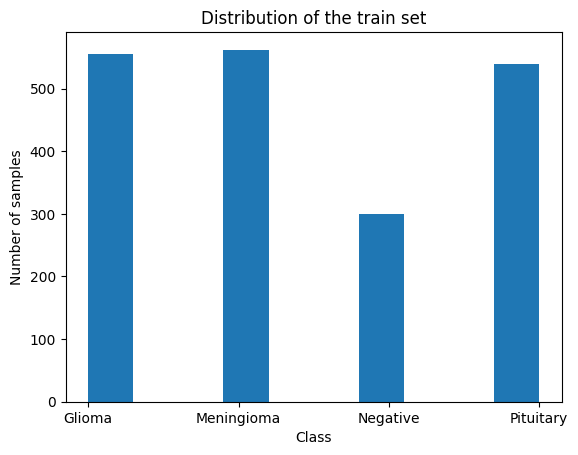

In [ ]:
glioma_samples = [entry for entry in train_entries if 'glioma' in entry]
meningioma_samples = [entry for entry in train_entries if 'meningioma' in entry]
negative_samples = [entry for entry in train_entries if 'no' in entry]
pituitary_samples = [entry for entry in train_entries if 'pituitary' in entry]

# Creo la lista dei label per la classe positiva
glioma_labels = ['Glioma'] * len(glioma_samples)

# Creo la lista dei label per la classe negativa
meningioma_labels = ['Meningioma'] * len(meningioma_samples)

# Creo la lista dei label per la classe positiva
negative_labels = ['Negative'] * len(negative_samples)

# Creo la lista dei label per la classe negativa
pituitary_labels = ['Pituitary'] * len(pituitary_samples)

# Unisco le due liste
labels = glioma_labels + meningioma_labels + negative_labels + pituitary_labels

# Creo l'istogramma
fig, ax = plt.subplots()
ax.hist(labels)

# Aggiungo le etichette
ax.set_xticks(['Glioma', 'Meningioma', 'Negative', 'Pituitary'])
ax.set_xlabel('Class')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of the train set')

plt.show()

At this point we calculate how many entries we have to consdier for each class and then we calculate, if needed, how many images we have to generate with data augmentation for the minority class.

In [ ]:
expected_samples_per_class = len(train_entries)//4
print("Number of expected images per class: " + str(expected_samples_per_class) + '\n')

glioma_tumor = random.sample(glioma_samples, expected_samples_per_class)
print("Number of sampled GLIOMA tumor images: " + str(len(glioma_tumor)))

meningioma_tumor = random.sample(meningioma_samples, expected_samples_per_class)
print("Number of sampled MENINGIOMA tumor images: " + str(len(meningioma_tumor)))

pituitary_tumor = random.sample(meningioma_samples, expected_samples_per_class)
print("Number of sampled PITUITARY tumor images: " + str(len(pituitary_tumor)))

negative_samples_needed = expected_samples_per_class - len(negative_samples)
sampled_negative = random.sample(negative_samples, negative_samples_needed)
print("\nNumber of sampled NEGATIVE tumor images: " + str(len(negative_samples)))
print("Number of sampled NEGATIVE tumor images to perform augmentation: " + str(len(sampled_negative)))


Number of expected images per class: 489

Number of sampled GLIOMA tumor images: 489
Number of sampled MENINGIOMA tumor images: 489
Number of sampled PITUITARY tumor images: 489

Number of sampled NEGATIVE tumor images: 300
Number of sampled NEGATIVE tumor images to perform augmentation: 189


# **Data Augmentation**

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range=0.1,  # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

# **CNN from scratch**


In [ ]:
# Definire un modello sequenziale di Keras
model = Sequential()

# Aggiungere un layer convoluzionale con 32 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))

# Aggiungere un layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 64 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un altro layer convoluzionale con 128 filtri, dimensione del kernel di 3x3, funzione di attivazione ReLU e padding "same"
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

# Aggiungere un altro layer di max pooling con dimensione 2x2
model.add(MaxPooling2D((2, 2)))

# Aggiungere un layer di appiattimento per convertire l'output del layer precedente in un vettore unidimensionale
model.add(Flatten())

# Aggiungere un layer completamente connesso con 512 unità e funzione di attivazione ReLU
model.add(Dense(512, activation='relu'))

# Aggiungere un layer di dropout con una percentuale di dropout di 0,5
model.add(Dropout(0.5))

# Aggiungere un altro layer completamente connesso con 4 unità (una per ogni classe) e funzione di attivazione softmax
model.add(Dense(4, activation='softmax'))

# Stampa il riepilogo del modello
model.summary()


In [ ]:
# Compilare il modello con la funzione di loss "categorical_crossentropy" e l'ottimizzatore "adam"
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Definire i callbacks da utilizzare durante l'addestramento del modello
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

# Definire una lista di callbacks
callbacks_list = [reduce_lr, checkpoint]

# Addestrare il modello usando la lista di callbacks
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=callbacks_list)

# **STATS**

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **TO DO**

In [ ]:
y_score = model.predict(X_test)
y_pred = np.rint(y_score) # to have 0 or 1
y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
print("Classification report: ")
print(metrics.classification_report(y_true, y_pred, digits=4, labels=['0', '1', '2', '3']))
metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
# ROC curve
fpr,tpr,th = metrics.roc_curve(y_true,y_score)
roc_auc = metrics.roc_auc_score(y_true,y_score)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pandas as pd

# save train test and validation set into csv file

df = pd.DataFrame({'X': X_train, 'y': y_train})
df.to_csv('/content/drive/MyDrive/BrainTumorDataset/train.csv', index=False)

df = pd.DataFrame({'X': X_test, 'y': y_test})
df.to_csv('/content/drive/MyDrive/BrainTumorDataset/test.csv', index=False)

df = pd.DataFrame({'X': X_val, 'y': y_val})
df.to_csv('/content/drive/MyDrive/BrainTumorDataset/validation.csv', index=False)


# **UTILS**

In [ ]:
# augmentation

glioma_tumor_path = dataset_path + '/Preprocessed/Training/glioma_tumor/'
meningioma_tumor_path = dataset_path + '/Preprocessed/Training/meningioma_tumor/'
no_tumor_path = dataset_path + '/Preprocessed/Training/no_tumor/'
pituitary_tumor_path = dataset_path + '/Preprocessed/Training/pituitary_tumor/'

glioma_tumor_entries = os.listdir(glioma_tumor_path)
meningioma_entries = os.listdir(meningioma_tumor_path)
no_tumor_entries = os.listdir(no_tumor_path)
pituitary_tumor_entries = os.listdir(pituitary_tumor_path)

i = len(glioma_tumor_entries) + 1 
for entry in glioma_tumor_entries: # store cropped normal cell augmented images
  img = cv2.imread(glioma_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(glioma_tumor_path + 'Augmented_glioma_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1

i = len(meningioma_entries) + 1 
for entry in meningioma_entries: # store cropped normal cell augmented images
  img = cv2.imread(meningioma_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(meningioma_tumor_path + 'Augmented_meningioma_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1

i = len(no_tumor_entries) + 1 
for entry in no_tumor_entries: # store cropped normal cell augmented images
  img = cv2.imread(no_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(no_tumor_path + 'Augmented_no_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1

i = len(pituitary_tumor_entries) + 1 
for entry in pituitary_tumor_entries: # store cropped normal cell augmented images
  img = cv2.imread(pituitary_tumor_path + entry)
  augmented_img = random_flip_or_rotation(img)
  cv2.imwrite(pituitary_tumor_path + 'Augmented_pituitary_tumor_' + str(i) + '.jpg', augmented_img)
  i = i + 1